### Question 3:

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,LabelEncoder


In [3]:
data= pd.read_csv("./bank.csv")
df=data

In [4]:
#Let's calculate the percentage of missing values in each column.
perc_missing = pd.DataFrame((df.isna().sum()/len(df)) * 100,columns = ["Perecentage Missing"])
perc_missing
#sns.heatmap(df.isnull(), cbar=False)

,Perecentage Missing
age,0.0
job,0.0
marital,0.0
education,0.0
default,0.0
balance,0.0
housing,0.0
loan,0.0
contact,0.0
day,0.0


In [ ]:
corr_matrix = df.corr(method="pearson",numeric_only = True)
corr_matrix

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.112300,-0.000762,0.000189,-0.005278,0.002774,0.020169
balance,0.112300,1.000000,0.010467,0.022436,-0.013894,0.017411,0.030805
day,-0.000762,0.010467,1.000000,-0.018511,0.137007,-0.077232,-0.058981
duration,0.000189,0.022436,-0.018511,1.000000,-0.041557,-0.027392,-0.026716
campaign,-0.005278,-0.013894,0.137007,-0.041557,1.000000,-0.102726,-0.049699
pdays,0.002774,0.017411,-0.077232,-0.027392,-0.102726,1.000000,0.507272
previous,0.020169,0.030805,-0.058981,-0.026716,-0.049699,0.507272,1.000000


#### Question 3 Answer:
* With stratified split, one can mention the variable from which equal portions should be taken for both test and train.

* Here i split train and test into 80/20.Then i split train data again into train and validation with 80 /20 split.

In [143]:
#split training and testing:
train,test = train_test_split(df, test_size=0.2, stratify=df["deposit"], random_state=42)

In [144]:
train["deposit"].value_counts()/len(train)

no     0.526151
yes    0.473849
Name: deposit, dtype: float64

In [145]:
test["deposit"].value_counts()/len(test)

no     0.526198
yes    0.473802
Name: deposit, dtype: float64

For validation set, gridsearch CV automatically splits the train and multiple cross validation data sets with 80/20 split.

### Modelling

In [146]:
#split into X and Y and encode the Target variable with categorical encoding
x_train,x_test =train.drop(columns=["deposit"]),test.drop(columns=["deposit"])
y_train,y_test = train["deposit"],test["deposit"]
encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)

In [147]:
#check which category it encodes into:
encode.transform(["no"])

array([0])

In [148]:
#one hot encoding for nominal and label encoder for ordinal
binary_categorical_features = ["marital","default","loan","contact","job","month","poutcome","housing"]
ordinal_categorical_features = ["education"]
target_column = ["deposit"]
numeric_features = ["age","balance","previous","pdays","campaign","duration","day"]

Creating pre-processing pipeline

In [149]:
columnTransformer = ColumnTransformer(
    transformers=[('bin_cat', OneHotEncoder(handle_unknown='ignore' ), binary_categorical_features),
                  ('ord_cat',OrdinalEncoder(),ordinal_categorical_features),
     ('num', StandardScaler(), numeric_features)])

x_train = columnTransformer.fit_transform(x_train)

In [150]:
x_train

array([[ 0.        ,  1.        ,  0.        , ...,  0.17848144,
        -0.34398786,  1.81720843],
       [ 0.        ,  1.        ,  0.        , ..., -0.5400311 ,
        -0.3179716 , -1.50481988],
       [ 0.        ,  0.        ,  1.        , ..., -0.5400311 ,
        -0.48563192, -0.55566894],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.5400311 ,
        -0.48852261, -1.74210762],
       [ 0.        ,  1.        ,  0.        , ..., -0.5400311 ,
         0.54345553, -1.26753215],
       [ 0.        ,  1.        ,  0.        , ..., -0.5400311 ,
        -0.71688752, -0.67431281]])

### Question 4 A:
Softmax Regression for binomial class

* Hyperparameter = C

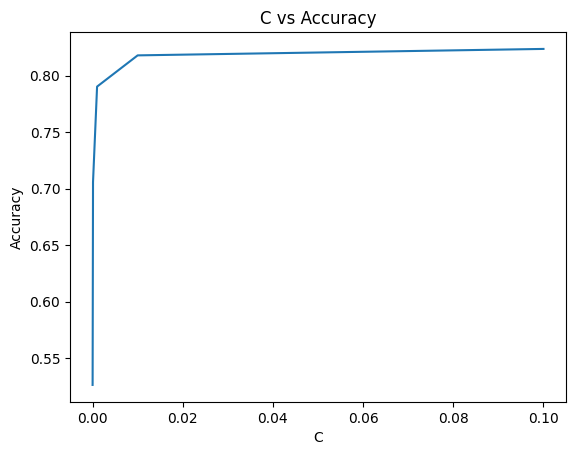

In [78]:
softmax_reg = LogisticRegression()
#automatic stratified split happens here
C = [0.000001, 0.00001, 0.0001,0.001,0.01, 0.1]
param_grid = {
    'C': C}
grid_search = GridSearchCV(softmax_reg, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(x_train, y_train)
results = grid_search.cv_results_
accuracy_scores = results["mean_test_score"]
sns.lineplot(x=C, y=accuracy_scores)
# Add labels and a title
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('C vs Accuracy')

# Show the plot
plt.show()

One can see that, when C is small[regularization parameter), the accuracy is less. Lesses the C, stronger the regularization. But as we increase C, the accuracy also increases, decreasing the amount of regularization,

In [79]:
scores = pd.DataFrame(data =C,columns=["C"])
scores["accuracy_scores"] = accuracy_scores
scores

,C,accuracy_scores
0,0.000001,0.526151
1,0.000010,0.527047
2,0.000100,0.705790
3,0.001000,0.790346
4,0.010000,0.818008
5,0.100000,0.823720


* Hyperparameter = Solver

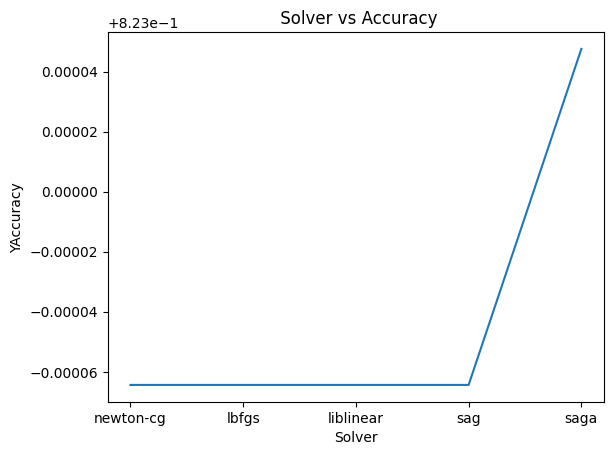

In [85]:
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
param_grid = {
    'solver': solver}
grid_search = GridSearchCV(softmax_reg, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(x_train, y_train)
results = grid_search.cv_results_
accuracy_scores = results["mean_test_score"]
sns.lineplot(x=solver, y=accuracy_scores)
# Add labels and a title
plt.xlabel('Solver')
plt.ylabel('YAccuracy')
plt.title(' Solver vs Accuracy')
# Show the plot
plt.show()



In [86]:
scores = pd.DataFrame(data =solver,columns=["Solver"])
scores["accuracy_scores"] = accuracy_scores
scores

,Solver,accuracy_scores
0,newton-cg,0.822936
1,lbfgs,0.822936
2,liblinear,0.822936
3,sag,0.822936
4,saga,0.823048


Almost all the solvers have same accuracy scores apart from saga, which is effecient for large datasets[111,000 observations]. It also has varienty of penalty parameters such as l1,l2 and elastic net making it very versatile and suitable for binary and multiclass classification

* Max number of Iterations

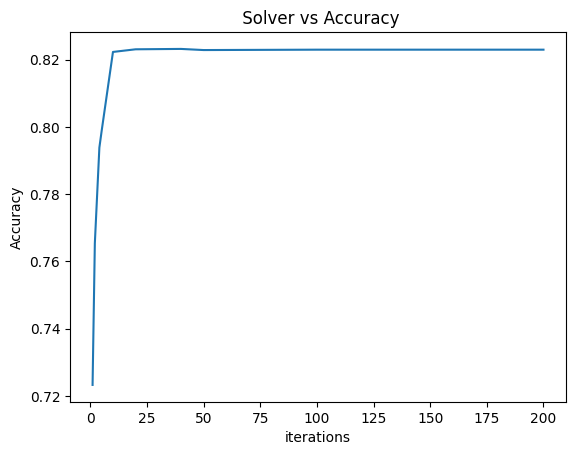

In [87]:
max_iter= [1,2,4,5,10,20,40,50,100,200]
param_grid = {
    'max_iter': max_iter}
grid_search = GridSearchCV(softmax_reg, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(x_train, y_train)
results = grid_search.cv_results_
accuracy_scores = results["mean_test_score"]
sns.lineplot(x=max_iter, y=accuracy_scores)
# Add labels and a title
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.title(' Solver vs Accuracy')

# Show the plot
plt.show()


In [88]:
scores = pd.DataFrame(data = max_iter,columns=["max_iter"])
scores["accuracy_scores"] = accuracy_scores
scores

,max_iter,accuracy_scores
0,1,0.723261
1,2,0.765371
2,4,0.793819
3,5,0.798746
4,10,0.822264
5,20,0.823048
6,40,0.823160
7,50,0.822824
8,100,0.822936
9,200,0.822936


increasing the max_iter increases the accuracy scores. But after a particular range it becomes constant. Logistic regression algorithms are trained using optimization Algorithms such as gradient descent where the model converges to the local minima after certain number of iterations. hence providing with ebough iteration is important.

* Find the best hyperparameters for Logistic Regression

In [89]:
#find best model
param_grid = {
    'C': [ 0.001, 0.01,0.1, 1.0, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [10,50,100,200, 300, 500]
}
grid_search = GridSearchCV(softmax_reg, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring="accuracy",return_train_score=True)
grid_search.fit(x_train, y_train)
print("\ntuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("\naccuracy :",grid_search.best_score_)


tuned hpyerparameters :(best parameters)  {'C': 0.1, 'max_iter': 10, 'solver': 'liblinear'}

accuracy : 0.8240559471268911


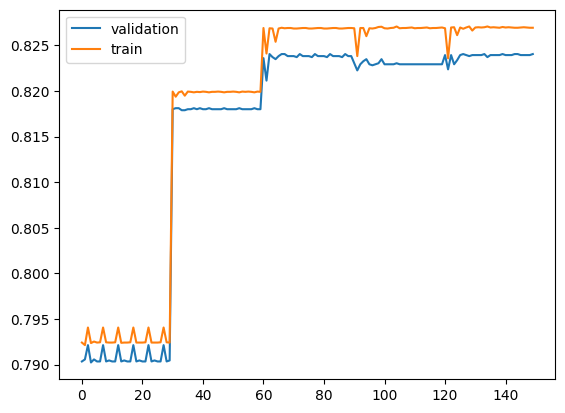

In [90]:
#plot graph
validation_scores = grid_search.cv_results_['mean_test_score']
train_scores = grid_search.cv_results_['mean_train_score']
plt.plot(validation_scores, label='validation')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

* fit the model with best parameters

In [93]:
from sklearn.metrics import classification_report, confusion_matrix
best_log_model = grid_search.best_estimator_
y_pred = best_log_model.predict(columnTransformer.fit_transform(x_test))
# Compute precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print(classification_report(y_test, y_pred))

Precision: 0.8338278931750742
Recall: 0.7967863894139886
F1 Score: 0.8148864185596907
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1175
           1       0.83      0.80      0.81      1058

    accuracy                           0.83      2233
   macro avg       0.83      0.83      0.83      2233
weighted avg       0.83      0.83      0.83      2233



--------------------------------------------------------------------------------------------------------------

### 4b: SVMs

In [94]:
#SVMs
from sklearn.svm import SVC
svm = SVC(probability=True)

* Hyperparameter : C

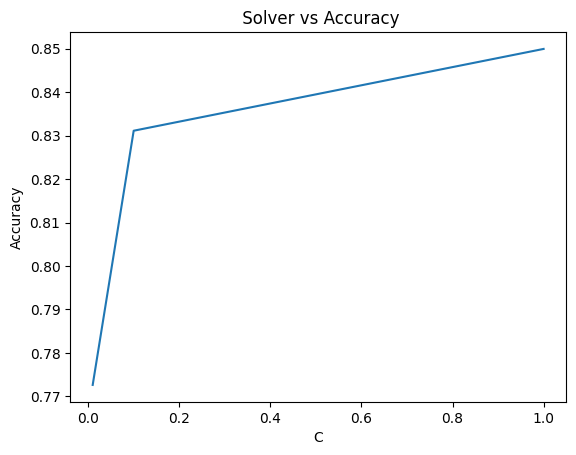

In [95]:
C=[0.01,0.1,1.0]
param_grid = {
    'C': C}
grid_search = GridSearchCV(svm, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(x_train, y_train)
results = grid_search.cv_results_
accuracy_scores = results["mean_test_score"]
sns.lineplot(x=C, y=accuracy_scores)
# Add labels and a title
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title(' Solver vs Accuracy')
# Show the plot
plt.show()

One can see that, when C is small[regularization parameter), the accuracy is less. Lesses the C, stronger the regularization. But as we increase C, the accuracy also increases, decreasing the amount of regularization.

In [75]:
scores = pd.DataFrame(data = C,columns=["C"])
scores["accuracy_scores"] = accuracy_scores
scores

,C,accuracy_scores
0,0.01,0.772651
1,0.10,0.831112
2,1.00,0.849927


* Hyperparameter: Kernel

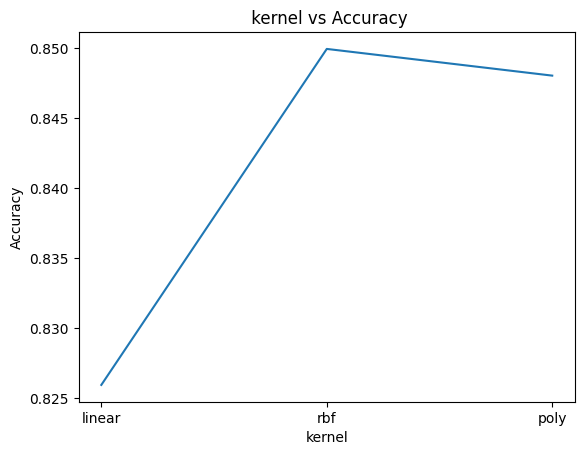

In [76]:
kernel=['linear', 'rbf', 'poly']
param_grid = {
    'kernel': kernel}
grid_search = GridSearchCV(svm, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(x_train, y_train)
results = grid_search.cv_results_
accuracy_scores = results["mean_test_score"]
sns.lineplot(x=kernel, y=accuracy_scores)
# Add labels and a title
plt.xlabel('kernel')
plt.ylabel('Accuracy')
plt.title(' kernel vs Accuracy')
# Show the plot
plt.show()

In [96]:
scores = pd.DataFrame(data = kernel,columns=["Kernel"])
scores["accuracy_scores"] = accuracy_scores
scores

,Kernel,accuracy_scores
0,linear,0.772651
1,rbf,0.831112
2,poly,0.849927


Ine can see that rbf kernel has higher accuracy compared to other kernels.Because the use case in hand is complex and may have decision boundaries that are complex, rbf kernel with its ability to create non linear transformation has performed better.

* Hyperparameter Gamma

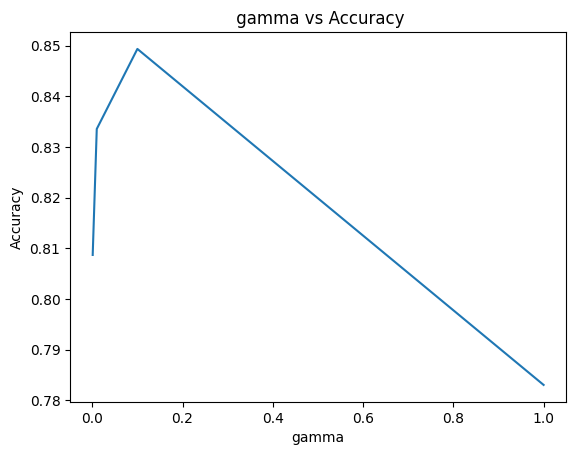

In [97]:
gamma= [0.001, 0.01, 0.1, 1]
param_grid = {
    'gamma': gamma}
grid_search = GridSearchCV(svm, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(x_train, y_train)
results = grid_search.cv_results_
accuracy_scores = results["mean_test_score"]
sns.lineplot(x=gamma, y=accuracy_scores)
# Add labels and a title
plt.xlabel('gamma')
plt.ylabel('Accuracy')
plt.title(' gamma vs Accuracy')
# Show the plot
plt.show()

In [98]:
scores = pd.DataFrame(data = gamma,columns=["Gamma"])
scores["accuracy_scores"] = accuracy_scores
scores

,Gamma,accuracy_scores
0,0.001,0.808713
1,0.010,0.833576
2,0.100,0.849367
3,1.000,0.783066


gamma parameter defines how smooth and generalized athe decsion bounday has to be. Higher the gamma, closely it fits to the training samples leading to overfitting which in turn decrease accuracy.

* Hyperparameter : Polynomial degree

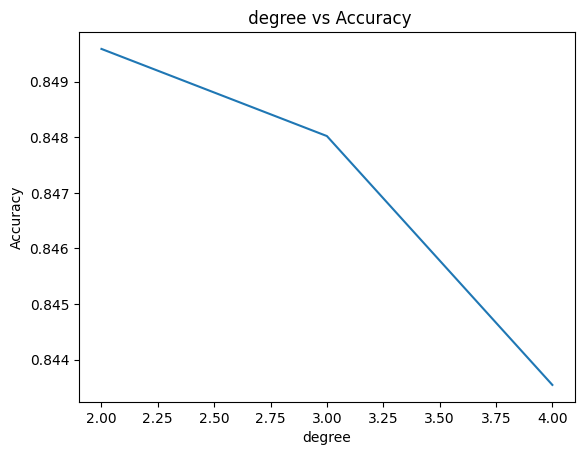

In [99]:
degree= [2, 3, 4]
param_grid = {
    'degree': degree}
grid_search = GridSearchCV(SVC(kernel="poly"), param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(x_train, y_train)
results = grid_search.cv_results_
accuracy_scores = results["mean_test_score"]
sns.lineplot(x=degree, y=accuracy_scores)
# Add labels and a title
plt.xlabel('degree')
plt.ylabel('Accuracy')
plt.title(' degree vs Accuracy')
# Show the plot
plt.show()

In [100]:
scores = pd.DataFrame(data = degree,columns=["degree"])
scores["accuracy_scores"] = accuracy_scores
scores

,degree,accuracy_scores
0,2,0.849591
1,3,0.848022
2,4,0.843543


a lower polynomial degree is used when the variables are linearly separable.Increasing the number of degress leads to model being overft, which inturn reduces the testing accuracy.

* find and fit the best model to SVM



tuned hpyerparameters :(best parameters)  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
accuracy : 0.8465672374140567


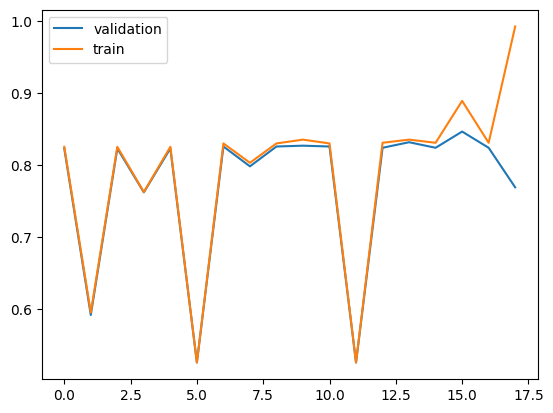

In [156]:
#best model
param_grid = {
    'C': [0.01,0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1]
}
grid_search = GridSearchCV(svc, param_grid=param_grid,
                           cv=2, n_jobs=-1, scoring="accuracy",return_train_score=True)
grid_search.fit(x_train, y_train)
print("\n")
print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)
validation_scores = grid_search.cv_results_['mean_test_score']
train_scores = grid_search.cv_results_['mean_train_score']
plt.plot(validation_scores, label='validation')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

* print performance metrics for best model

In [102]:
from sklearn.metrics import classification_report, confusion_matrix
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(columnTransformer.fit_transform(x_test))
# Compute precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print(classification_report(y_test, y_pred))

Precision: 0.8269402319357716
Recall: 0.8761814744801513
F1 Score: 0.8508490133088572
              precision    recall  f1-score   support

           0       0.88      0.83      0.86      1175
           1       0.83      0.88      0.85      1058

    accuracy                           0.85      2233
   macro avg       0.85      0.86      0.85      2233
weighted avg       0.86      0.85      0.85      2233



### 4c  Random Forest Classifier

In [103]:
#random forest
from sklearn.ensemble import RandomForestClassifier

In [104]:
rf_clf = RandomForestClassifier()

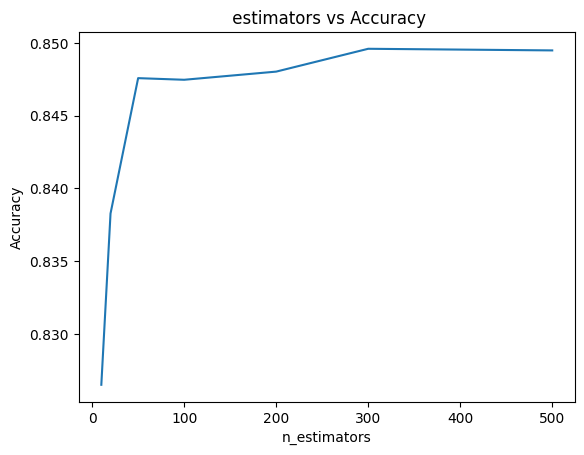

In [105]:
n_estimators=[10,20,50, 100, 200, 300, 500]
param_grid = {
    'n_estimators': n_estimators}
grid_search = GridSearchCV(rf_clf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(x_train, y_train)
results = grid_search.cv_results_
accuracy_scores = results["mean_test_score"]
sns.lineplot(x=n_estimators, y=accuracy_scores)
# Add labels and a title
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title(' estimators vs Accuracy')
# Show the plot
plt.show()

In [106]:
scores = pd.DataFrame(data = n_estimators,columns=["n_estimators"])
scores["accuracy_scores"] = accuracy_scores
scores

,n_estimators,accuracy_scores
0,10,0.826520
1,20,0.838279
2,50,0.847575
3,100,0.847463
4,200,0.848023
5,300,0.849591
6,500,0.849479


n_estimators defines the number of decision trees that needs to be created. higher the decsion tree, the probability of overfitting increases, and lower it is, the model might be underfit. In this scenario, one can see that the accuracy starts to decrease when estimators increase from 300-500, which means the model is overfitting.

* Hyper-parameter : max_depth

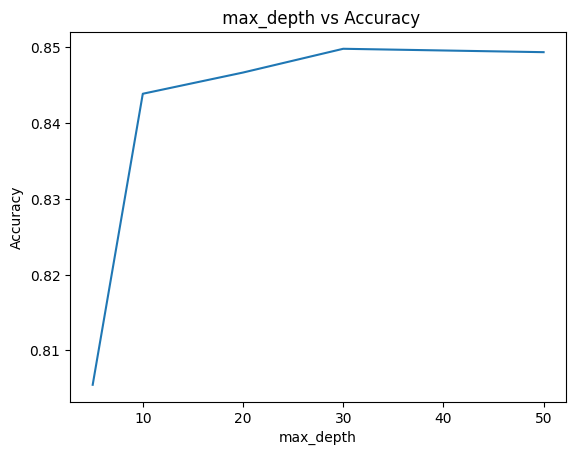

In [107]:
max_depth= [0, 5, 10, 20, 30,50]
param_grid = {
    'max_depth': max_depth}
grid_search = GridSearchCV(rf_clf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(x_train, y_train)
results = grid_search.cv_results_
accuracy_scores = results["mean_test_score"]
sns.lineplot(x=max_depth, y=accuracy_scores)
# Add labels and a title
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title(' max_depth vs Accuracy')
# Show the plot
plt.show()

In [108]:
scores = pd.DataFrame(data = max_depth,columns=["max_depth"])
scores["accuracy_scores"] = accuracy_scores
scores

,max_depth,accuracy_scores
0,0,NaN
1,5,0.805465
2,10,0.843879
3,20,0.846679
4,30,0.849815
5,50,0.849367


Lesser max_depth results in trees that are simpler and less complex. But as you increase the max_depth, the accuracy increases and starts decreasing after reaching the highest accuracy as the model will start to overfit.

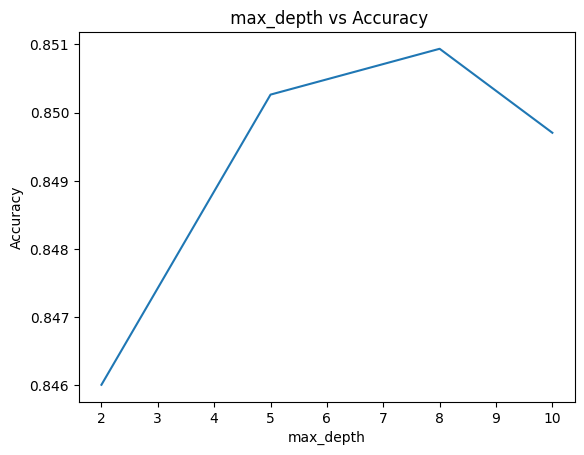

In [109]:
min_samples_split= [1,2, 5, 8,10]
param_grid = {
    'min_samples_split': min_samples_split}
grid_search = GridSearchCV(rf_clf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(x_train, y_train)
results = grid_search.cv_results_
accuracy_scores = results["mean_test_score"]
sns.lineplot(x=min_samples_split, y=accuracy_scores)
# Add labels and a title
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title(' max_depth vs Accuracy')
# Show the plot
plt.show()

In [110]:
scores = pd.DataFrame(data = min_samples_split,columns=["min_samples_split"])
scores["accuracy_scores"] = accuracy_scores
scores

,min_samples_split,accuracy_scores
0,1,NaN
1,2,0.846006
2,5,0.850263
3,8,0.850935
4,10,0.849703


A samll "min samples split" means it allows the nodes to split even when there are less samples at node, which may lead to overfitting.

* hyperparameter = min_samples_leaf

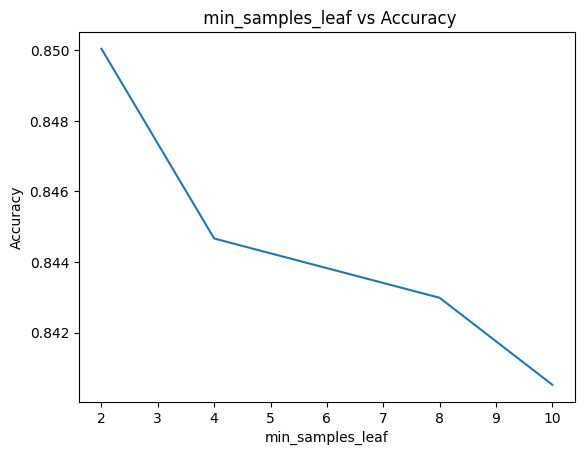

In [111]:
min_samples_leaf= [2,4,8,10]  # Minimum number of samples required to be at a leaf node
param_grid = {
    'min_samples_leaf': min_samples_leaf}
grid_search = GridSearchCV(rf_clf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(x_train, y_train)
results = grid_search.cv_results_
accuracy_scores = results["mean_test_score"]
sns.lineplot(x=min_samples_leaf, y=accuracy_scores)
# Add labels and a title
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title(' min_samples_leaf vs Accuracy')
# Show the plot
plt.show()

In [112]:
scores = pd.DataFrame(data = min_samples_leaf,columns=["min_samples_leaf"])
scores["accuracy_scores"] = accuracy_scores
scores

,min_samples_leaf,accuracy_scores
0,2,0.850038
1,4,0.844663
2,8,0.842983
3,10,0.840519


increasing the min_samples_leaf makes the model underfit the data as the trees becomes shallower and simpler, inturn reducing the overall accuracy.

* find the best parameter

In [113]:
param_grid = {
    'n_estimators': [50, 100],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of each tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

tuned hpyerparameters :(best parameters)  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
accuracy : 0.8512705418113493


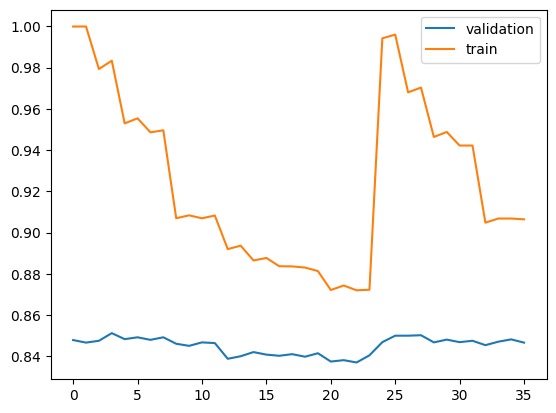

In [114]:
grid_search = GridSearchCV(rf_clf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring="accuracy",return_train_score=True)
grid_search.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

validation_scores = grid_search.cv_results_['mean_test_score']
train_scores = grid_search.cv_results_['mean_train_score']
plt.plot(validation_scores, label='validation')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

* fit the best set of hyperparameters

In [115]:
best_rf_clf_model = grid_search.best_estimator_
y_pred = best_rf_clf_model.predict(columnTransformer.fit_transform(x_test))
# Compute precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print(classification_report(y_test, y_pred))

Precision: 0.8252853380158033
Recall: 0.888468809073724
F1 Score: 0.8557123350022757
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1175
           1       0.83      0.89      0.86      1058

    accuracy                           0.86      2233
   macro avg       0.86      0.86      0.86      2233
weighted avg       0.86      0.86      0.86      2233



Question 5: Ensemble Techniques

i.Voting Classifier

In [158]:

#voting classifer
from sklearn.ensemble import VotingClassifier,AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
def Voting_classifier(method):
  ensemble_classifier = VotingClassifier(estimators = [("log",best_log_model),("rf",best_rf_clf_model)],voting="soft")
  ensemble_classifier.fit(x_train,y_train)
  ensemble_predictions = ensemble_classifier.predict(columnTransformer.fit_transform(x_test))
  # Evaluate the ensemble's performance
  ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
  print(method,"Voting classifier Results")
  print("Ensemble Test Accuracy for Voting Classifier:", ensemble_accuracy)
  for name, clf in ensemble_classifier.named_estimators_.items():
    print(name, "=", clf.score(columnTransformer.fit_transform(x_test), y_test))
Voting_classifier("hard")

hard Voting classifier Results
Ensemble Test Accuracy for Voting Classifier: 0.8540080609046127
log = 0.8284818629646216
rf = 0.8616211374832065


In [159]:
Voting_classifier("soft")

soft Voting classifier Results
Ensemble Test Accuracy for Voting Classifier: 0.8490819525302284
log = 0.8284818629646216
rf = 0.8584863412449619


ii. Adaboost

In [161]:
ensemble_classifier = VotingClassifier(estimators = [("log",best_log_model),("rf",best_rf_clf_model)],voting="soft")
adaBoostClassifier = AdaBoostClassifier(estimator = ensemble_classifier,n_estimators=100,)
adaBoostClassifier.fit(x_train,y_train)

AdaBoostClassifier(estimator=VotingClassifier(estimators=[('log',
                                                           LogisticRegression(C=0.1,
                                                                              max_iter=10,
                                                                              solver='liblinear')),
                                                          ('rf',
                                                           RandomForestClassifier(min_samples_split=5))],
                                              voting='soft'),
                   n_estimators=100)

In [163]:
ensemble_predictions = adaBoostClassifier.predict(columnTransformer.fit_transform(x_test))
# Evaluate the ensemble's performance
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Ensemble Accuracy for Adaboost:", ensemble_accuracy)

Ensemble Accuracy for Adaboost: 0.8625167935512763


iii. Bagging with DecsionTreeClassifier

In [166]:
#bagging
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(x_train, y_train)
bagging_predictions = bag_clf.predict(columnTransformer.fit_transform(x_test))
# Evaluate the ensemble's performance
bagging_accuracy = accuracy_score(y_test, bagging_predictions)
print("Ensemble Accuracy for bagging:", bagging_accuracy)

Ensemble Accuracy for bagging: 0.8159426780116436


iv. Gradient Boosting

In [168]:
#gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=3,n_iter_no_change=20 )
gb_classifier.fit(x_train, y_train)
gb_predictions = gb_classifier.predict(columnTransformer.fit_transform(x_test))
gb_accuracy = accuracy_score(y_test, gb_predictions)
print("Gradient Boosting Classifier Accuracy:", gb_accuracy)

Gradient Boosting Classifier Accuracy: 0.8598298253470668


v. Stacking Classifier

In [169]:
from sklearn.ensemble import StackingClassifier
stacking_clf = StackingClassifier(estimators=[('lr', best_log_model),('rf', best_rf_clf_model)],
                                   final_estimator=best_log_model,
                                   cv=10)
stacking_clf.fit(x_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('lr',
                                LogisticRegression(C=0.1, max_iter=10,
                                                   solver='liblinear')),
                               ('rf',
                                RandomForestClassifier(min_samples_split=5))],
                   final_estimator=LogisticRegression(C=0.1, max_iter=10,
                                                      solver='liblinear'))

In [171]:
stacking_pred = stacking_clf.predict(columnTransformer.fit_transform(x_test))
stacking_accuracy = accuracy_score(y_test, stacking_pred)
print("Gradient Boosting Classifier Accuracy:", stacking_accuracy)

Gradient Boosting Classifier Accuracy: 0.8557993730407524


### 4c Continued for Feature importance:

Precision: 0.8254385964912281
Recall: 0.889413988657845
F1 Score: 0.8562329390354868
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1175
           1       0.83      0.89      0.86      1058

    accuracy                           0.86      2233
   macro avg       0.86      0.86      0.86      2233
weighted avg       0.86      0.86      0.86      2233

Feature ranking:
1. feature 11 (0.389672)
2. feature 5 (0.080905)
3. feature 0 (0.080606)
4. feature 10 (0.080358)
5. feature 9 (0.066613)
6. feature 13 (0.053780)
7. feature 8 (0.046544)
8. feature 15 (0.035253)
9. feature 1 (0.033910)
10. feature 6 (0.030800)
11. feature 12 (0.029987)
12. feature 14 (0.022965)
13. feature 3 (0.020260)
14. feature 2 (0.015718)
15. feature 7 (0.011101)
16. feature 4 (0.001526)


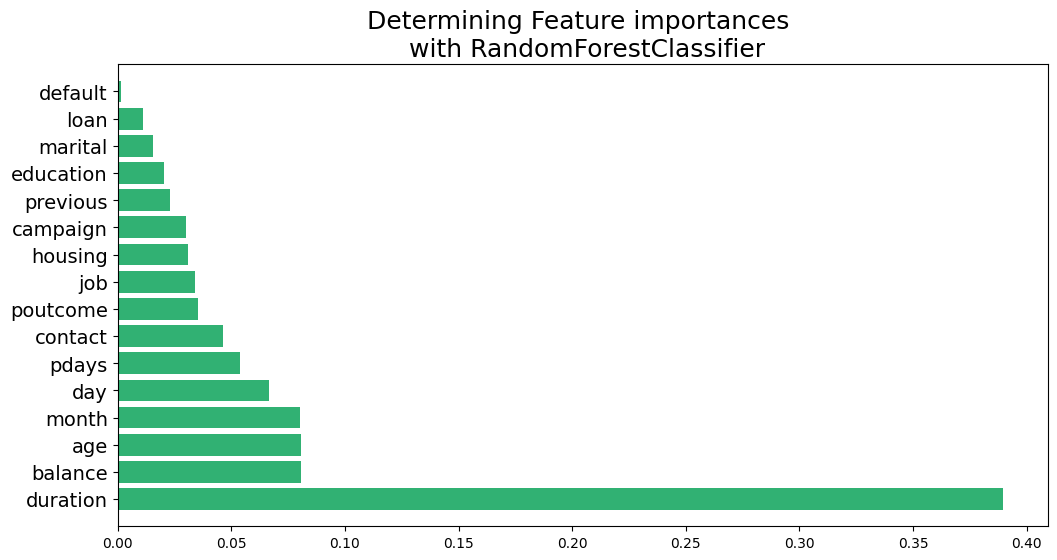

In [172]:
# Convert the columns into categorical variables
df['job'] = df['job'].astype('category').cat.codes
df['marital'] = df['marital'].astype('category').cat.codes
df['education'] = df['education'].astype('category').cat.codes
df['contact'] = df['contact'].astype('category').cat.codes
df['poutcome'] = df['poutcome'].astype('category').cat.codes
df['month'] = df['month'].astype('category').cat.codes
df['default'] = df['default'].astype('category').cat.codes
df['loan'] = df['loan'].astype('category').cat.codes
df['housing'] = df['housing'].astype('category').cat.codes
df['deposit'] = df['deposit'].astype('category').cat.codes

x = df.drop(columns=["deposit"])
y = df["deposit"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y)
rf_clf = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 100)
rf_clf.fit(x_train,y_train)
y_pred = rf_clf.predict(x_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print(classification_report(y_test, y_pred))

importances = rf_clf.feature_importances_
feature_names = x_test.columns
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Determining Feature importances \n with RandomForestClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#31B173',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

From the above graph. once can see that, duration is the most important feature that defines whether a customer decides to open a term deposit or not.